# ДЗ1. CLAP. Обучение проекции из аудио в текстовое пространство CLIP

**Описание задания**

В этом задании вы построите упрощённый вариант модели CLAP (Contrastive Language-Audio Pretraining):

- аудио прогоняется через предобученный аудио-энкодер (например, `LanguageBindAudio`, `CNN14/16` или другой);
- текстовое описание пропускается через предобученный текстовый энкодер CLIP;
- поверх аудио-векторов обучается линейный адаптер, который отображает аудио в то же пространство, что и текстовые эмбеддинги CLIP;
- обучение идёт по *контрастивному лоссу*, все энкодеры заморожены, обучаются только параметры аудио-проекции (и, при желании, температура в лоссе);
- качество полученного аудио-текстового пространства оценивается на задаче классификации / retrieval аудио по текстам на `AudioCaps`.

Идея оценки: если всё сделано правильно, для аудио и его описания косинусное сходство эмбеддингов будет выше, чем для аудио и нерелевантных текстов.


**Формулировка задач**

0. Выбор аудио-энкодера.
   Выберите и обоснуйте предобученный аудио-энбеддер:  
   - `LanguageBindAudio`,  
   - или CNN-модель (например, PANNs CNN14/16),  
   - или другой открытый аудио-энкодер, который выдаёт фиксированный эмбеддинг.

1. Подсчёт эмбеддингов.
   - Посчитайте аудио-векторы для всех аудио из `AudioCaps` с помощью выбранного энкодера.  
   - Посчитайте текстовые векторы для подписей с помощью `CLIP text encoder`.

2. Линейная аудио-проекция.
   - Реализуйте модель `AudioProjection`, переводящую аудио-эмбеддинг в размерность текстового эмбеддинга CLIP.

3. Контрастивное обучение.
   - Обучите аудио-проекцию на датасете `AudioCaps` по схеме аудио ↔ текст с контрастивным лоссом.  
   - Аудио-энкодер и CLIP должны быть полностью заморожены.

4. Оценка качества.
   - Оцените качество полученного аудио-текстового пространства на задаче классификации/ретривала аудио:  
     для каждого аудио найдите наиболее похожую текстовую подпись в батче/валидации и посчитайте `accuracy@1/3/10`.  
   - Сравните результаты с *случайным бейзлайном*.


### Сеттинг

> Подготовьте все необходимые импорты и загрузите необходимые данные.

In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import Wav2Vec2Processor, Wav2Vec2Model  # для wav2vec2
import clip  # для CLIP
import soundfile as sf  # для загрузки .flac файлов
from sklearn.metrics import top_k_accuracy_score # для accuracy@k в Задании 4

from pathlib import Path
from tqdm import tqdm

# для красивого вывода
from rich.console import Console
from rich.table import Table


In [2]:
# Можно скачать AudioCaps напрямую из kaggle
# файл с ключом должен быть в ~/.kaggle/kaggle.json
# !kaggle datasets download nickkar30/audiocaps

In [3]:
# Для загрузки AudioCaps можно воспользоваться этим кодом

# !gdown --id 1FAVKNWXp5afgoNmclDwnj8j_OFTBRmIb -O audiocaps.zip
# !gdown --id 1fWZ0DN6IbSdjM_N0zTKyDQbypP053Y5l -O audiocaps.zip
# !unzip -q audiocaps.zip -d audiocaps

DATA_ROOT = "./audiocaps/audiocaps"
print("Files in DATA_ROOT:", os.listdir(DATA_ROOT))

Files in DATA_ROOT: ['audiocaps_test_new.tsv', 'val_texts.json', 'test_texts.json', 'audiocaps_train.tsv', 'audio', 'audiocaps_test.tsv', 'audiocaps_val_new.tsv', 'audiocaps_val.tsv']


### Задание 1. Подготовка аудио- и текстовых энкодеров (2 балла)

В этом задании вам нужно:

1. Выбрать аудио-энкодер и инициализировать его.
2. Инициализировать текстовый энкодер CLIP. Вы свободны выбирать самостоятельно, какой имеено.
3. Заморозить параметры обоих энкодеров (мы не дообучаем их, а учим только линейный адаптер).

Вы можете:

* использовать `LanguageBindAudio` (потребует установки репозитория и зависимостей);
* или подставить свою аудио-модель (главное - чтобы на выходе был вектор фиксированной размерности).


In [4]:
# your code here
# ┌(ಠ_ಠ)┘
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# Инициализация аудио-энкодера wav2vec2
print("Загружаем wav2vec2 ...")
audio_model_name = "facebook/wav2vec2-base"
audio_processor = Wav2Vec2Processor.from_pretrained(audio_model_name)
audio_model = Wav2Vec2Model.from_pretrained(audio_model_name).to(device)

# Заморозка параметров wav2vec2
for param in audio_model.parameters():
    param.requires_grad = False
audio_model.eval()
print(f"Wav2Vec2 загружен. Размерность аудио-эмбеддинга: {audio_model.config.hidden_size}")

# Инициализация текстового энкодера CLIP
print("Загружаем CLIP ...")
clip_model_name = "ViT-B/32"
clip_model, clip_preprocess = clip.load(clip_model_name, device=device)

# Заморозка параметров CLIP
for param in clip_model.parameters():
    param.requires_grad = False
clip_model.eval()

# Проверка размерности текстовых эмбеддингов CLIP
test_text = clip.tokenize(["test"]).to(device)
with torch.no_grad():
    test_text_embedding = clip_model.encode_text(test_text)
clip_text_dim = test_text_embedding.shape[-1]
print(f"CLIP загружен. Размерность текстового эмбеддинга: {clip_text_dim}")


Device: cuda
Загружаем wav2vec2 ...


/home/yc-user/hse-fcs-multimodal-course/.venv/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Wav2Vec2 загружен. Размерность аудио-эмбеддинга: 768
Загружаем CLIP ...
CLIP загружен. Размерность текстового эмбеддинга: 512


### Задание 2. Предподсчёт аудио- и текстовых эмбеддингов (3 балла)

> Важный момент, который пригодится вам и в других домашних.

Чтобы не тратить время на многократный прогон энкодеров при обучении, следует:

1. Предварительно посчитывать аудио-эмбеддинги для каждого `.flac` в train/val/test.
2. Записывать их в файл формата `pickle` (например), где ключ - имя файла, значение - numpy-вектор.
3. Аналогично посчитать текстовые эмбеддинги для подписей через CLIP и совместить их с аудио.

Рекомендуемая структура:

* функция `extract_audio_vectors_with_checkpointing(...)` - обходит файлы, считает эмбеддинги, периодически делает чекпоинты;
* функция `extract_text_embeddings(texts, clip_model, clip_processor)` - возвращает список текстовых эмбеддингов;
* функция `process_dataset(...)` - читает `.tsv`, мержит аудио-эмбеддинги и текстовые, сохраняет список словарей вида  
  `{"uniq_id": ..., "audio_embedding": ..., "text_embedding": ...}` в pickle.

> Вы вольны отходить от предлагаемой структуры.

In [5]:
# your code here (づ｡◕‿‿◕｡)づ

# Служебные функции для обработки аудио и текста

def load_audio_file(audio_path, target_sr=16000):
    """
    Загружает аудио файл и ресемплирует до целевой частоты дискретизации.
    
    Args:
        audio_path: путь к аудио файлу (.flac)
        target_sr: целевая частота дискретизации (по умолчанию 16kHz для wav2vec2)
    
    Returns:
        waveform: numpy array с аудио данными, shape (n_samples,)
    """
    try:
        # Загружаем через soundfile, т.к. он работает с .flac без torchcodec
        waveform, sample_rate = sf.read(str(audio_path), dtype='float32')
        
        # Конвертируем в моно (если стерео)
        if len(waveform.shape) > 1:
            waveform = np.mean(waveform, axis=1)
        
        # Ресемплинг до целевой частоты, если нужно
        if sample_rate != target_sr:
            # Используем torchaudio для ресемплинга (более точный)
            waveform_tensor = torch.from_numpy(waveform).unsqueeze(0)
            resampler = torchaudio.transforms.Resample(sample_rate, target_sr)
            waveform_tensor = resampler(waveform_tensor)
            waveform = waveform_tensor.squeeze(0).numpy()
        
        return waveform
    except Exception as e:
        print(f"Ошибка загрузки аудио файла {audio_path}: {e}")
        return None


def extract_audio_embedding(audio_path: str, audio_processor, audio_model, device, data_root=None):
    """
    Извлекает эмбеддинг из аудио файла с помощью wav2vec2.
    
    Args:
        audio_path: путь к аудио файлу (может быть относительным или абсолютным)
                    (в TSV файлах путь имеет вид "audiocaps/audio/val/0.flac")
        audio_processor: Wav2Vec2Processor
        audio_model: Wav2Vec2Model (должна быть в eval режиме и на device)
        device: устройство (cuda/cpu)
        data_root: корневая директория (например, DATA_ROOT "./audiocaps/audiocaps")
    
    Returns:
        audio_embedding: numpy array размерности [hidden_size] (768 для wav2vec2-base)
                         или None в случае ошибки
    """
    try:
        # Формируем полный путь
        if data_root:
            # Если путь уже содержит "audiocaps/", убираем его
            if audio_path.startswith("audiocaps/"):
                audio_path = audio_path[len("audiocaps/"):]
            full_path = Path(data_root) / audio_path
        else:
            full_path = Path(audio_path)
        
        # Проверка наличия файла
        if not full_path.exists():
            print(f"Аудио файл не найден: {full_path}")
            return None
        
        # Загружаем аудио
        waveform = load_audio_file(full_path)
        if waveform is None:
            return None
        
        # Пропускаем через wav2vec2
        inputs = audio_processor(waveform, sampling_rate=16000, return_tensors="pt", padding=True)
        input_values = inputs.input_values.to(device)
        
        # Извлекаем эмбеддинг
        with torch.no_grad():
            outputs = audio_model(input_values)  # [batch, seq_len, hidden_size]
            # Mean pooling по оси времени seq_len
            audio_embedding = outputs.last_hidden_state.mean(dim=1)  # [batch, hidden_size]
            audio_embedding = audio_embedding.squeeze(0).cpu().numpy()  # [hidden_size]
        
        return audio_embedding
    
    except Exception as e:
        print(f"Ошибка извлечения эмбеддинга из {audio_path}: {e}")
        return None


def extract_text_embeddings(texts, clip_model, device, batch_size=32):
    """
    Извлекает текстовые эмбеддинги для списка текстов с помощью CLIP.
    
    Args:
        texts: список строк с текстами
        clip_model: CLIP модель (должна быть в eval режиме и на device)
        device: устройство (cuda/cpu)
        batch_size: размер батча для обработки
    
    Returns:
        all_embeddings: список numpy массивов, каждый размерности [text_dim] (512 для CLIP ViT-B/32)
    """
    all_embeddings = []
    
    # Идем по батчам
    for i in tqdm(range(0, len(texts), batch_size), desc="Извлечение текстовых эмбеддингов", total=len(texts) // batch_size):
        batch_texts = texts[i:i + batch_size]
        
        # Токенизация
        text_tokens = clip.tokenize(batch_texts).to(device)
        
        # Получаем эмбеддинги
        with torch.no_grad():
            text_embeddings = clip_model.encode_text(text_tokens)
            text_embeddings = text_embeddings.cpu().numpy()
        
        all_embeddings.extend(text_embeddings)
    
    return all_embeddings


In [6]:
# Тест служебных функций на одном примере
print("Тест служебных функций...")
# Берем путь как в TSV файле: "audiocaps/audio/val/0.flac"
test_audio_path_tsv = "audiocaps/audio/val/0.flac"
# Или прямой путь для теста load_audio_file
test_audio_path_direct = Path(DATA_ROOT) / "audio/val/0.flac"

if test_audio_path_direct.exists():
    print(f"\n1. Загрузка аудио файла: {test_audio_path_direct}")
    test_waveform = load_audio_file(test_audio_path_direct)
    if test_waveform is not None:
        print(f"   Загружен: shape={test_waveform.shape}, dtype={test_waveform.dtype}")
    
    print(f"\n2. Тест `extract_audio_embedding` с путем как в TSV: {test_audio_path_tsv}")
    test_audio_emb = extract_audio_embedding(test_audio_path_tsv, audio_processor, audio_model, device, DATA_ROOT)
    if test_audio_emb is not None:
        print(f"   Аудио-эмбеддинг: shape={test_audio_emb.shape}")
else:
    print(f"  [WARN] Файл не найден: {test_audio_path_direct}")

print("\n3. Тест `extract_text_embeddings` (на 2 примерах)")
test_texts = ["Нельзя просто взять и обучить модель", "Путь к успеху лежит через страдания"]
test_text_embs = extract_text_embeddings(test_texts, clip_model, device, batch_size=2)
if test_text_embs:
    print(f"   Текстовые эмбеддинги: {len(test_text_embs)} штуки, shape={test_text_embs[0].shape}")


Тест служебных функций...

1. Загрузка аудио файла: audiocaps/audiocaps/audio/val/0.flac
   Загружен: shape=(160000,), dtype=float32

2. Тест `extract_audio_embedding` с путем как в TSV: audiocaps/audio/val/0.flac
   Аудио-эмбеддинг: shape=(768,)

3. Тест `extract_text_embeddings` (на 2 примерах)


Извлечение текстовых эмбеддингов: 100%|██████████| 1/1 [00:00<00:00, 98.60it/s]

   Текстовые эмбеддинги: 2 штуки, shape=(512,)


In [7]:
# Основные функции для задания 3

def extract_audio_vectors_with_checkpointing(
    tsv_path, 
    audio_processor, 
    audio_model, 
    device, 
    data_root,
    checkpoint_dir="./checkpoints",
    checkpoint_interval=1000,
    split_name=""
):
    """
    Извлекает аудио-эмбеддинги для всех аудио из TSV файла с поддержкой чекпоинтинга.
    
    Args:
        tsv_path: путь к TSV файлу с данными
        audio_processor: Wav2Vec2Processor
        audio_model: Wav2Vec2Model
        device: устройство (cuda/cpu)
        data_root: корневая директория для аудио файлов
        checkpoint_dir: директория для сохранения чекпоинтов
        checkpoint_interval: интервал сохранения чекпоинтов (количество файлов)
        split_name: имя сплита (train/val/test) для имени файла чекпоинта
    
    Returns:
        audio_embeddings_dict: словарь {uniq_id: numpy_array}
    """
    # Создаём директорию для чекпоинтов
    Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)
    
    # Имя файла чекпоинта
    checkpoint_file = Path(checkpoint_dir) / f"audio_embeddings_{split_name}.pkl"
    
    # Загружаем существующий чекпоинт, если есть
    audio_embeddings_dict = {}
    if checkpoint_file.exists():
        print(f"Загрузка чекпоинта из {checkpoint_file}...")
        with checkpoint_file.open('rb') as f:
            audio_embeddings_dict = pickle.load(f)
        print(f"Загружено {len(audio_embeddings_dict)} эмбеддингов из чекпоинта")
    
    # Читаем TSV файл
    print(f"Чтение TSV файла: {tsv_path}")
    df = pd.read_csv(tsv_path, sep='\t')
    print(f"Всего строк в TSV: {len(df)}")
    
    # Обрабатываем аудио файлы
    processed_count = 0
    skipped_count = 0
    error_count = 0
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Извлечение аудио-эмбеддингов ({split_name})"):
        uniq_id = row['uniq_id']
        audio_path = row['audio']
        
        # Пропускаем, если уже обработано
        if uniq_id in audio_embeddings_dict:
            skipped_count += 1
            continue
        
        # Извлекаем эмбеддинг
        audio_embedding = extract_audio_embedding(
            audio_path, 
            audio_processor, 
            audio_model, 
            device, 
            data_root
        )
        
        if audio_embedding is not None:
            audio_embeddings_dict[uniq_id] = audio_embedding
            processed_count += 1
        else:
            error_count += 1
            print(f" [WARN] Не удалось извлечь эмбеддинг для uniq_id={uniq_id}, audio={audio_path}")
        
        # Сохраняем чекпоинт периодически
        if processed_count > 0 and processed_count % checkpoint_interval == 0:
            print(f"Сохранение чекпоинта после {processed_count} обработанных файлов...")
            with checkpoint_file.open('wb') as f:
                pickle.dump(audio_embeddings_dict, f)
    
    # Финальное сохранение
    print("Сохранение финального чекпоинта...")
    with checkpoint_file.open('wb') as f:
        pickle.dump(audio_embeddings_dict, f)
    
    print("\nИзвлечение аудио-эмбеддингов завершено!")
    print(f"   - Обработано: {processed_count}")
    print(f"   - Пропущено (уже в чекпоинте): {skipped_count}")
    print(f"   - Ошибки: {error_count}")
    print(f"   - Всего эмбеддингов: {len(audio_embeddings_dict)}")
    
    return audio_embeddings_dict


def process_dataset(
    tsv_path,
    audio_processor,
    audio_model,
    clip_model,
    device,
    data_root,
    checkpoint_dir="./checkpoints",
    split_name="",
    checkpoint_interval=1000
):
    """
    Обрабатывает датасет: извлекает аудио- и текстовые эмбеддинги и сохраняет в pickle.
    
    Args:
        tsv_path: путь к TSV файлу
        audio_processor: Wav2Vec2 Processor
        audio_model: Wav2Vec2 Model
        clip_model: CLIP модель
        device: устройство (cuda/cpu)
        data_root: корневая директория для аудио файлов
        checkpoint_dir: директория для чекпоинтов
        split_name: имя сплита (train/val/test)
        checkpoint_interval: интервал сохранения чекпоинтов
    
    Returns:
        dataset: список словарей вида {"uniq_id": ..., "audio_embedding": ..., "text_embedding": ..., ...}
    """
    print(f"\n{'='*60}")
    print(f"Обработка датасета: {split_name}")
    print(f"{'='*60}")
    
    print("\nШаг 1: Извлечение аудио-эмбеддингов...")
    audio_embeddings_dict = extract_audio_vectors_with_checkpointing(
        tsv_path,
        audio_processor,
        audio_model,
        device,
        data_root,
        checkpoint_dir,
        checkpoint_interval,
        split_name
    )
    
    print(f"\nШаг 2: Чтение TSV файла {tsv_path}")
    df = pd.read_csv(tsv_path, sep='\t')
    texts = df['text'].tolist()
    uniq_ids = df['uniq_id'].tolist()
    audio_paths = df['audio'].tolist()
    
    print("\nШаг 3: Извлечение текстовых эмбеддингов...")
    text_embeddings = extract_text_embeddings(texts, clip_model, device, batch_size=32)
    
    print("\nШаг 4: Объединение аудио- и текстовых эмбеддингов...")
    dataset = []
    missing_audio_count = 0
    
    for i, uniq_id in enumerate(uniq_ids):
        if uniq_id in audio_embeddings_dict:
            dataset.append({
                "uniq_id": uniq_id,
                "audio_embedding": audio_embeddings_dict[uniq_id],
                "text_embedding": text_embeddings[i],
                "text": texts[i],  # для отладки, можно удалить
                "audio_path": audio_paths[i]  # для отладки, можно удалить
            })
        else:
            missing_audio_count += 1
            print(f" [WARN] Отсутствует аудио-эмбеддинг для uniq_id={uniq_id}")
    
    # Сохраняем финальный датасет
    output_file = Path(checkpoint_dir) / f"embeddings_{split_name}.pkl"
    print(f"\nШаг 5: Сохранение объединенного датасета в {output_file}...")
    with output_file.open('wb') as f:
        pickle.dump(dataset, f)
    
    print("\nОбработка датасета завершена!")
    print(f"   - Всего образцов: {len(dataset)}")
    print(f"   - Отсутствуют аудио-эмбеддинги: {missing_audio_count}")
    print(f"   - Сохранено в: {output_file}")
    
    return dataset



In [8]:
# Обработка датасетов
checkpoint_dir = "./checkpoints"

val_tsv = str(Path(DATA_ROOT) / "audiocaps_val_new.tsv")
val_dataset = process_dataset(
    val_tsv,
    audio_processor,
    audio_model,
    clip_model,
    device,
    DATA_ROOT,
    checkpoint_dir,
    split_name="val",
    checkpoint_interval=100
)

test_tsv = str(Path(DATA_ROOT) / "audiocaps_test_new.tsv")
test_dataset = process_dataset(
    test_tsv,
    audio_processor,
    audio_model,
    clip_model,
    device,
    DATA_ROOT,
    checkpoint_dir,
    split_name="test",
    checkpoint_interval=100
)

train_tsv = str(Path(DATA_ROOT) / "audiocaps_train.tsv")
train_dataset = process_dataset(
    train_tsv,
    audio_processor,
    audio_model,
    clip_model,
    device,
    DATA_ROOT,
    checkpoint_dir,
    split_name="train",
    checkpoint_interval=1000
)



Обработка датасета: val

Шаг 1: Извлечение аудио-эмбеддингов...
Загрузка чекпоинта из checkpoints/audio_embeddings_val.pkl...
Загружено 495 эмбеддингов из чекпоинта
Чтение TSV файла: audiocaps/audiocaps/audiocaps_val_new.tsv
Всего строк в TSV: 495


Извлечение аудио-эмбеддингов (val): 100%|██████████| 495/495 [00:00<00:00, 20706.52it/s]


Сохранение финального чекпоинта...

Извлечение аудио-эмбеддингов завершено!
   - Обработано: 0
   - Пропущено (уже в чекпоинте): 495
   - Ошибки: 0
   - Всего эмбеддингов: 495

Шаг 2: Чтение TSV файла audiocaps/audiocaps/audiocaps_val_new.tsv

Шаг 3: Извлечение текстовых эмбеддингов...


Извлечение текстовых эмбеддингов: 16it [00:00, 82.31it/s]                       



Шаг 4: Объединение аудио- и текстовых эмбеддингов...

Шаг 5: Сохранение объединенного датасета в checkpoints/embeddings_val.pkl...

Обработка датасета завершена!
   - Всего образцов: 495
   - Отсутствуют аудио-эмбеддинги: 0
   - Сохранено в: checkpoints/embeddings_val.pkl

Обработка датасета: test

Шаг 1: Извлечение аудио-эмбеддингов...
Загрузка чекпоинта из checkpoints/audio_embeddings_test.pkl...
Загружено 963 эмбеддингов из чекпоинта
Чтение TSV файла: audiocaps/audiocaps/audiocaps_test_new.tsv
Всего строк в TSV: 963


Извлечение аудио-эмбеддингов (test): 100%|██████████| 963/963 [00:00<00:00, 22513.95it/s]


Сохранение финального чекпоинта...

Извлечение аудио-эмбеддингов завершено!
   - Обработано: 0
   - Пропущено (уже в чекпоинте): 963
   - Ошибки: 0
   - Всего эмбеддингов: 963

Шаг 2: Чтение TSV файла audiocaps/audiocaps/audiocaps_test_new.tsv

Шаг 3: Извлечение текстовых эмбеддингов...


Извлечение текстовых эмбеддингов: 31it [00:00, 90.19it/s]                        



Шаг 4: Объединение аудио- и текстовых эмбеддингов...

Шаг 5: Сохранение объединенного датасета в checkpoints/embeddings_test.pkl...

Обработка датасета завершена!
   - Всего образцов: 963
   - Отсутствуют аудио-эмбеддинги: 0
   - Сохранено в: checkpoints/embeddings_test.pkl

Обработка датасета: train

Шаг 1: Извлечение аудио-эмбеддингов...
Загрузка чекпоинта из checkpoints/audio_embeddings_train.pkl...
Загружено 49490 эмбеддингов из чекпоинта
Чтение TSV файла: audiocaps/audiocaps/audiocaps_train.tsv
Всего строк в TSV: 49490


Извлечение аудио-эмбеддингов (train): 100%|██████████| 49490/49490 [00:02<00:00, 24366.50it/s]


Сохранение финального чекпоинта...

Извлечение аудио-эмбеддингов завершено!
   - Обработано: 0
   - Пропущено (уже в чекпоинте): 49490
   - Ошибки: 0
   - Всего эмбеддингов: 49490

Шаг 2: Чтение TSV файла audiocaps/audiocaps/audiocaps_train.tsv

Шаг 3: Извлечение текстовых эмбеддингов...


Извлечение текстовых эмбеддингов: 1547it [00:16, 95.78it/s]                          



Шаг 4: Объединение аудио- и текстовых эмбеддингов...

Шаг 5: Сохранение объединенного датасета в checkpoints/embeddings_train.pkl...

Обработка датасета завершена!
   - Всего образцов: 49490
   - Отсутствуют аудио-эмбеддинги: 0
   - Сохранено в: checkpoints/embeddings_train.pkl


### Задание 3. Линейный аудио-адаптер и контрастивный лосс (3 балла)


Теперь, когда у нас есть пары *audio_embedding, text_embedding*, реализуем:

1. Класс `AudioTextDataset`, который читает pickle с комбинированными эмбеддингами.
2. Линейную модель `AudioProjection`, переводящую аудио-эмбеддинг в размерность текстового.
3. Контрастивный лосс для аудио↔текст:
   - нормализовать эмбеддинги по L2;
   - посчитать матрицу сходства;
   - задать таргеты как `targets = arange(batch_size)`;
   - вычислить `CrossEntropyLoss` как для строк audio→text и для строк text→audio, усреднить.

Обучаем **только** `AudioProjection` (и, по желанию, параметр temperature).


In [9]:
# your code here
# (╯°□°）╯︵ ┻━┻

class AudioTextDataset(Dataset):
    """
    Датасет для загрузки пар аудио-текстовых эмбеддингов из pickle файла.
    """
    def __init__(self, pickle_path):
        """
        Args:
            pickle_path: путь к pickle файлу с эмбеддингами
        """
        with Path(pickle_path).open('rb') as f:
            self.data = pickle.load(f)
        
        print(f"Загружен датасет из {pickle_path}: {len(self.data)} образцов")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        """
        Returns:
            audio_embedding: numpy array [768] - аудио-эмбеддинг
            text_embedding: numpy array [512] - текстовый эмбеддинг
        """
        sample = self.data[idx]
        audio_emb = sample['audio_embedding']  # numpy array [768]
        text_emb = sample['text_embedding']   # numpy array [512]
        
        # Конвертируем в torch tensors
        audio_emb = torch.from_numpy(audio_emb).float()
        text_emb = torch.from_numpy(text_emb).float()
        
        return audio_emb, text_emb


class AudioProjection(nn.Module):
    """
    Линейная проекция аудио-эмбеддингов в пространство текстовых эмбеддингов CLIP.
    """
    def __init__(self, audio_dim=768, text_dim=512, init_scale=1.0, dropout=0.1, hidden_dim=None):
        """
        Args:
            audio_dim: размерность аудио-эмбеддинга (768 для wav2vec2-base)
            text_dim: размерность текстового эмбеддинга (512 для CLIP ViT-B/32)
            init_scale: масштаб инициализации весов
            dropout: вероятность dropout для регуляризации (0.0 = без dropout)
            hidden_dim: размерность скрытого слоя (None = линейная проекция)
        """
        super(AudioProjection, self).__init__()
        self.hidden_dim = hidden_dim
        self.projection = nn.Linear(audio_dim, text_dim if hidden_dim is None else hidden_dim, bias=False)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        if hidden_dim is not None:
            self.projection2 = nn.Linear(hidden_dim, text_dim, bias=False)
        
        # Инициализация: небольшие случайные веса
        nn.init.normal_(self.projection.weight, std=0.02 * init_scale)
    
    def forward(self, audio_embeddings):
        """
        Args:
            audio_embeddings: тензор [batch_size, audio_dim]
        
        Returns:
            x: тензор [batch_size, text_dim]
        """
        x = self.projection(audio_embeddings)
        x = self.dropout(x)
        if self.hidden_dim is not None:
            x = self.projection2(x)
        return x

# Контрастивный лосс (InfoNCE-style)
def contrastive_loss(audio_embeddings, text_embeddings, temperature=0.07):
    """
    Вычисляет контрастивный лосс для пар аудио-текст.
    
    Args:
        audio_embeddings: тензор [batch_size, text_dim] - спроецированные аудио-эмбеддинги
        text_embeddings: тензор [batch_size, text_dim] - текстовые эмбеддинги
        temperature: параметр температуры для масштабирования логитов
    
    Returns:
        loss: скалярный тензор - усреднённый контрастивный лосс
        logits_audio_to_text: [batch_size, batch_size] - матрица сходства audio→text
        logits_text_to_audio: [batch_size, batch_size] - матрица сходства text→audio
    """
    batch_size = audio_embeddings.shape[0]
    
    # L2-нормализация эмбеддингов (как в CLIP)
    audio_embeddings = F.normalize(audio_embeddings, p=2, dim=-1)
    text_embeddings = F.normalize(text_embeddings, p=2, dim=-1)
    
    # Т.к. векторы нормализованы, то это матрица косинусного сходства [batch_size, batch_size]
    logits_audio_to_text = torch.matmul(audio_embeddings, text_embeddings.T) / temperature
    
    # Транспонированная матрица для обратного направления
    logits_text_to_audio = logits_audio_to_text.T
    
    # Таргеты: диагональ матрицы (i-й аудио соответствует i-му тексту)
    labels = torch.arange(batch_size, device=audio_embeddings.device)
    
    # CrossEntropyLoss в обоих направлениях
    loss_audio_to_text = F.cross_entropy(logits_audio_to_text, labels)
    loss_text_to_audio = F.cross_entropy(logits_text_to_audio, labels)
    
    # Усредняем оба направления
    loss = (loss_audio_to_text + loss_text_to_audio) / 2.0
    
    return loss, logits_audio_to_text, logits_text_to_audio


# Функция обучения
def train_audio_projection(
    model,
    train_loader,
    val_loader,
    device,
    num_epochs=10,
    learning_rate=5e-4,
    initial_temperature=0.07,
    use_learnable_temperature=True,
    print_interval=100,
    weight_decay=5e-4,
    min_temperature=0.02,
    lr_scheduler_factor=0.5,
    lr_scheduler_patience=3,
    early_stopping_patience=5,
):
    """
    Обучает модель AudioProjection с контрастивным лоссом.
    
    Args:
        model: экземпляр AudioProjection
        train_loader: DataLoader для обучающего датасета
        val_loader: DataLoader для валидационного датасета (может быть None)
        device: устройство (cuda/cpu)
        num_epochs: количество эпох
        learning_rate: скорость обучения
        initial_temperature: начальное значение температуры
        use_learnable_temperature: обучать ли параметр temperature
        print_interval: интервал вывода лосса (в итерациях)
        weight_decay: коэффициент weight decay для регуляризации
        min_temperature: минимальное значение температуры
        lr_scheduler_factor: фактор уменьшения learning rate
        lr_scheduler_patience: терпение для LR scheduler (эпохи без улучшения)
        early_stopping_patience: Ранняя остановка после N эпох без улучшения val loss
    
    Returns:
        train_losses: список значений лосса на обучении
        val_losses: список значений лосса на валидации
    """
    from torch.optim.lr_scheduler import ReduceLROnPlateau
    
    model = model.to(device)
    
    # Параметр температуры (опционально обучаемый)
    if use_learnable_temperature:
        temperature = nn.Parameter(torch.tensor(initial_temperature, device=device))
        optimizer = AdamW(
            list(model.parameters()) + [temperature], 
            lr=learning_rate,
            weight_decay=weight_decay
        )
    else:
        temperature = initial_temperature
        optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Шедулер для learning rate
    scheduler = ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=lr_scheduler_factor, 
        patience=lr_scheduler_patience
    )
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    
    print(f"\n{'='*60}")
    print("Начало обучения...")
    print(f"  - Устройство: {device}")
    print(f"  - Эпохи: {num_epochs}")
    print(f"  - Скорость обучения: {learning_rate}")
    print(f"  - Коэффициент регуляризации: {weight_decay}")
    print(f"  - Обучаемая температура: {use_learnable_temperature}")
    print(f"  - Начальная температура: {initial_temperature}")
    if use_learnable_temperature:
        print(f"  - Минимальная температура: {min_temperature}")
    print(f"  - Шедулер: ReduceLROnPlateau (factor={lr_scheduler_factor}, patience={lr_scheduler_patience})")
    print(f"{'='*60}\n")
    
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        num_batches = 0
        
        # Обучение
        for batch_idx, (audio_embs, text_embs) in enumerate(train_loader):
            audio_embs = audio_embs.to(device)
            text_embs = text_embs.to(device)
            
            # Проекция аудио-эмбеддингов
            audio_projected = model(audio_embs)
            
            # Ограничиваем температуру снизу
            if use_learnable_temperature:
                with torch.no_grad():
                    temperature.data.clamp_(min=min_temperature)
                current_temp = temperature
            else:
                current_temp = temperature
            
            # Контрастивный лосс
            loss, _, _ = contrastive_loss(audio_projected, text_embs, temperature=current_temp)
            
            # Шаг оптимизации
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Снова ограничиваем температуру после шага оптимизации
            if use_learnable_temperature:
                with torch.no_grad():
                    temperature.data.clamp_(min=min_temperature)
            
            epoch_train_loss += loss.item()
            num_batches += 1
            
            # Периодический вывод
            if (batch_idx + 1) % print_interval == 0:
                temp_val = temperature.item() if use_learnable_temperature else temperature
                current_lr = optimizer.param_groups[0]['lr']
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)}, "
                      f"Loss: {loss.item():.4f}, Temp: {temp_val:.4f}, LR: {current_lr:.6f}")
        
        avg_train_loss = epoch_train_loss / num_batches
        train_losses.append(avg_train_loss)
        
        # Валидация
        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            val_batches = 0
            
            with torch.no_grad():
                for audio_embs, text_embs in val_loader:
                    audio_embs = audio_embs.to(device)
                    text_embs = text_embs.to(device)
                    
                    audio_projected = model(audio_embs)
                    
                    current_temp = temperature if use_learnable_temperature else temperature
                    loss, _, _ = contrastive_loss(audio_projected, text_embs, temperature=current_temp)
                    
                    val_loss += loss.item()
                    val_batches += 1
            
            avg_val_loss = val_loss / val_batches if val_batches > 0 else 0.0
            val_losses.append(avg_val_loss)
            
            # Шаг шедулера LR
            scheduler.step(avg_val_loss)
            
            # Ранняя остановка
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                epochs_without_improvement = 0
                # Сохраняем лучшую модель
                best_model_state = model.state_dict().copy()
            else:
                epochs_without_improvement += 1
            
            current_temp = temperature.item() if use_learnable_temperature else temperature
            current_lr = optimizer.param_groups[0]['lr']
            print(f"\nЭпоха {epoch+1}/{num_epochs}:")
            print(f"  Loss: Train={avg_train_loss:.4f}, Val={avg_val_loss:.4f} (best: {best_val_loss:.4f})")
            print(f"  Temp: {current_temp:.4f}, LR: {current_lr:.6f}, Без улучшений: {epochs_without_improvement}/{early_stopping_patience}\n")
            
            # Ранняя остановка
            if epochs_without_improvement >= early_stopping_patience:
                print(f"Ранняя остановка! Нет улучшений для {early_stopping_patience} эпох.")
                print(f"Восстановление лучшей модели (val_loss={best_val_loss:.4f})...")
                model.load_state_dict(best_model_state)
                break
        else:
            current_temp = temperature.item() if use_learnable_temperature else temperature
            current_lr = optimizer.param_groups[0]['lr']
            print(f"\nЭпоха {epoch+1}/{num_epochs} завершена:")
            print(f"  Loss: Train={avg_train_loss:.4f}")
            print(f"  Temp: {current_temp:.4f}, LR: {current_lr:.6f}\n")
    
    print(f"{'='*60}")
    print("Обучение завершено!")
    if val_loader is not None:
        print(f"Лучший val_loss: {best_val_loss:.4f}")
    print(f"{'='*60}\n")
    
    return train_losses, val_losses



In [10]:
# Загружаем датасеты
train_dataset = AudioTextDataset("./checkpoints/embeddings_train.pkl")
val_dataset = AudioTextDataset("./checkpoints/embeddings_val.pkl")

# Создаём загрузчики
batch_size = 128  
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=3,  # параллелит чтение данных, пока GPU считает
    pin_memory=True if device == "cuda" else False  # ускоряет загрузку на GPU
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=2,
    pin_memory=True if device == "cuda" else False
)


Загружен датасет из ./checkpoints/embeddings_train.pkl: 49490 образцов
Загружен датасет из ./checkpoints/embeddings_val.pkl: 495 образцов



Начало обучения...
  - Устройство: cuda
  - Эпохи: 70
  - Скорость обучения: 0.0001
  - Коэффициент регуляризации: 0.1
  - Обучаемая температура: False
  - Начальная температура: 0.03
  - Шедулер: ReduceLROnPlateau (factor=0.5, patience=3)


Эпоха 1/70:
  Loss: Train=4.0579, Val=3.5563 (best: 3.5563)
  Temp: 0.0300, LR: 0.000100, Без улучшений: 0/6


Эпоха 2/70:
  Loss: Train=3.5870, Val=3.3826 (best: 3.3826)
  Temp: 0.0300, LR: 0.000100, Без улучшений: 0/6


Эпоха 3/70:
  Loss: Train=3.4484, Val=3.2968 (best: 3.2968)
  Temp: 0.0300, LR: 0.000100, Без улучшений: 0/6


Эпоха 4/70:
  Loss: Train=3.3684, Val=3.2350 (best: 3.2350)
  Temp: 0.0300, LR: 0.000100, Без улучшений: 0/6


Эпоха 5/70:
  Loss: Train=3.3119, Val=3.2054 (best: 3.2054)
  Temp: 0.0300, LR: 0.000100, Без улучшений: 0/6


Эпоха 6/70:
  Loss: Train=3.2640, Val=3.1669 (best: 3.1669)
  Temp: 0.0300, LR: 0.000100, Без улучшений: 0/6


Эпоха 7/70:
  Loss: Train=3.2318, Val=3.1564 (best: 3.1564)
  Temp: 0.0300, LR: 0.000100, Б

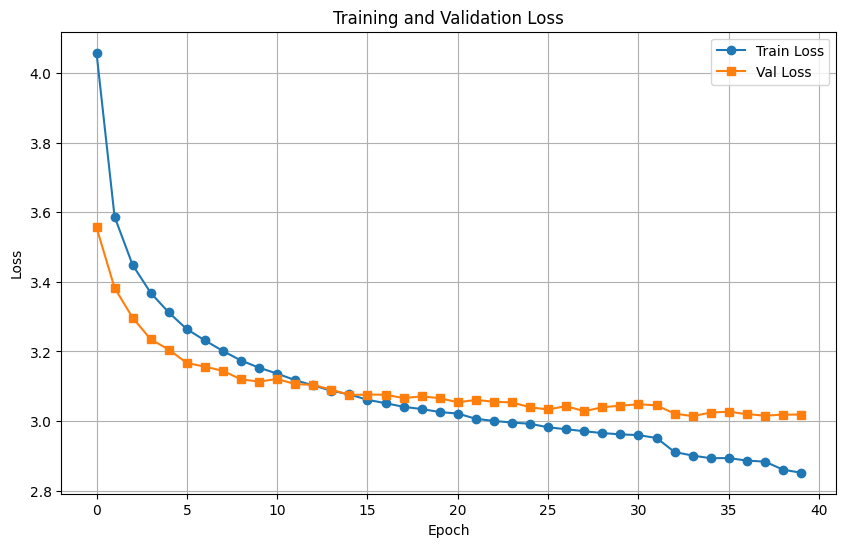

In [11]:
# Создаём модель
audio_projection = AudioProjection(audio_dim=768, text_dim=512, dropout=0.5, hidden_dim=1024)

# Обучаем
train_losses, val_losses = train_audio_projection(
    model=audio_projection,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_epochs=70,
    learning_rate=1e-4,  # 
    initial_temperature=0.03,
    use_learnable_temperature=False, # не обучаем температуру, т.к. она моментально падает до минимума
    print_interval=400,
    weight_decay=1e-1,  # Регуляризация для предотвращения переобучения
    min_temperature=0.03,  # 
    lr_scheduler_factor=0.5,  # Уменьшаем LR в 2 раза при отсутствии улучшения
    lr_scheduler_patience=3,  # Ждём 3 эпохи без улучшения перед уменьшением LR
    early_stopping_patience=6  # Останавливаем обучение после N эпох без улучшения val_loss
)

# Сохраняем модель
torch.save(audio_projection.state_dict(), "./checkpoints/audio_projection.pt")
print("Модель сохранена в ./checkpoints/audio_projection.pt")

# Визуализация лосса
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', marker='o')
if val_losses:
    plt.plot(val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

### Задание 4. Оценка качества на задаче классификации аудио (2 балла)


Теперь нужно понять, насколько хорошо аудио-векторы после проекции "попадают" в пространство текстовых эмбеддингов:

1. Посчитайте проекции аудио для всех примеров в валидации.
2. Для каждого аудио найдите `top-k` наиболее похожих текстов по косинусному сходству (или скалярному произведению после L2-нормализации).
3. Посчитайте `accuracy@1`, `accuracy@3`, `accuracy@10`, т.е. долю случаев, когда "правильный" текст попал в топ-k.
4. Сравните с неким *случайным бейзлайном*: для каждого аудио выберите `k` случайных текстов и посчитайте такую же метрику.

> Важно: в батче класс "правильного" текста для i-го аудио - это индекс i (как в контрастивном лоссе).

Загружаем обученную модель...
Модель загружена успешно!
Загружен датасет из ./checkpoints/embeddings_val.pkl: 495 образцов
Вычисляем проекции для всех примеров ...


Обрабатываем батчи: 100%|██████████| 16/16 [00:00<00:00, 1271.77it/s]


Аудио-эмбеддинги: (495, 512)
Текстовые эмбеддинги: (495, 512)

Вычисляем матрицу сходства...
Матрица сходства: (495, 495)
Диапазон значений: [-0.2155, 0.2909]

Вычисляем accuracy@k для k = [1, 3, 5, 7, 10, 15, 20] ...
Вычисляем случайный бейзлайн для k = [1, 3, 5, 7, 10, 15, 20] ...


                РЕЗУЛЬТАТЫ ACCURACY@K                 
┏━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃  k  ┃     Модель      ┃    Бейзлайн    ┃ Улучшение ┃
┡━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ @1  │ 0.1071 (10.71%) │ 0.0020 (0.20%) │  53.00x   │
├─────┼─────────────────┼────────────────┼───────────┤
│ @3  │ 0.2121 (21.21%) │ 0.0061 (0.61%) │  35.00x   │
├─────┼─────────────────┼────────────────┼───────────┤
│ @5  │ 0.2949 (29.49%) │ 0.0101 (1.01%) │  29.20x   │
├─────┼─────────────────┼────────────────┼───────────┤
│ @7  │ 0.3596 (35.96%) │ 0.0141 (1.41%) │  25.43x   │
├─────┼─────────────────┼────────────────┼───────────┤
│ @10 │ 0.4444 (44.44%) │ 0.0202 (2.02%) │  22.00x   │
├─────┼─────────────────┼────────────────┼───────────┤
│ @15 │ 0.5091 (50.91%) │ 0.0303 (3.03%) │  16.80x   │
├─────┼─────────────────┼────────────────┼───────────┤
│ @20 │ 0.5657 (56.57%) │ 0.0404 (4.04%) │  14.00x   │
└─────┴─────────────────┴────────────────┴───────────┘

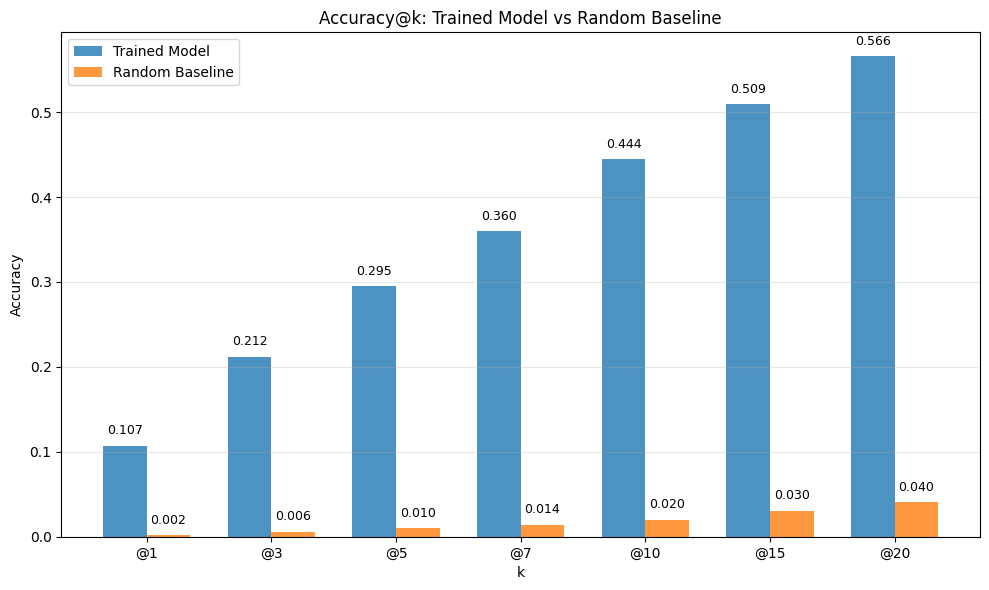

In [ ]:
# your code here
# (⌐■_■)

def compute_accuracy_at_k_sklearn(similarity_matrix, k_values):
    """
    Вычисляет accuracy@k для различных значений k, используя scikit-learn.

    Args:
        similarity_matrix: numpy array [n_audio, n_text] - матрица косинусного сходства
        k_values: список значений k для accuracy@k

    Returns:
        accuracies: словарь {k: accuracy@k}
    """
    n_audio, n_text = similarity_matrix.shape
    true_labels = np.arange(n_audio)
    
    accuracies = {}
    for k in k_values:
        accuracy = top_k_accuracy_score(
            true_labels, 
            similarity_matrix, 
            k=k,
            labels=np.arange(n_text)
        )
        accuracies[k] = accuracy
    
    return accuracies

# Эта ф-я не используется, реализовал для сравнения. 
# Результат совпадает с `compute_accuracy_at_k_sklearn`
def compute_accuracy_at_k(similarity_matrix, k_values):
    """
    Вычисляет accuracy@k для различных значений k

    Args:
        similarity_matrix: numpy array [n_audio, n_text] - матрица косинусного сходства
        k_values: список значений k для accuracy@k

    Returns:
        accuracies: словарь {k: accuracy@k}
    """
    n_audio, n_text = similarity_matrix.shape
    max_k = max(k_values)
    
    # Один раз сортируем все строки
    # argsort возвращает индексы от наименьшего к наибольшему
    sorted_indices = np.argsort(similarity_matrix, axis=1)  # [n_audio, n_text]
    
    # Берем последние max_k элементов и переворачиваем (от наибольшего к наименьшему)
    top_k_indices = sorted_indices[:, -max_k:][:, ::-1]  # [n_audio, max_k]
    
    # Правильные метки (диагональ) - расширяем для broadcasting
    true_labels = np.arange(n_audio)[:, None]  # [n_audio, 1]
    
    accuracies = {}
    for k in k_values:
        # Проверяем, есть ли правильный индекс в первых k элементах
        matches = (top_k_indices[:, :k] == true_labels).any(axis=1)
        accuracies[k] = matches.mean()
    
    return accuracies


def compute_random_baseline(n_audio, n_text, k_values):
    """
    Аналитически вычисляет accuracy@k для различных значений k для случайного бейзлайна.

    Args:
        n_audio: количество аудио
        n_text: количество текстов
        k_values: список значений k для accuracy@k

    Returns:
        accuracies: словарь {k: accuracy@k}
    """
    accuracies = {}
    for k in k_values:
        # Количество аудио, для которых есть правильный текст
        valid_audio = min(n_audio, n_text)
        
        # Вероятность попадания правильного текста в выборку
        if valid_audio > 0:
            p_hit = k / n_text
            # Учитываем только те аудио, у которых правильный текст существует
            accuracy = (valid_audio * p_hit) / n_audio
        else:
            accuracy = 0.0
        
        accuracies[k] = accuracy
    
    return accuracies


def evaluate_audio_text_retrieval(model, dataset, device, k_values, batch_size=32):
    """
    Оценивает качество retrieval аудио по текстам

    Args:
        model: обученная модель AudioProjection
        dataset: AudioTextDataset с валидационными данными
        device: устройство (cuda/cpu)
        batch_size: размер батча для обработки

    Returns:
        results: словарь с метриками и визуализациями
    """
    model.eval()
    model = model.to(device)

    audio_embeddings_list = []
    text_embeddings_list = []


    print("Вычисляем проекции для всех примеров ...")
    with torch.no_grad():
        for audio_embs, text_embs in tqdm(
            DataLoader(dataset, batch_size=batch_size, shuffle=False),
            desc="Обрабатываем батчи",
        ):
            audio_embs = audio_embs.to(device)
            text_embs = text_embs.to(device)

            # Проекция аудио-эмбеддингов
            audio_projected = model(audio_embs)

            # L2-нормализация (как в CLIP)
            audio_projected = F.normalize(audio_projected, p=2, dim=-1)
            text_embs = F.normalize(text_embs, p=2, dim=-1)

            audio_embeddings_list.append(audio_projected.cpu().numpy())
            text_embeddings_list.append(text_embs.cpu().numpy())

    # Объединяем все батчи
    audio_embeddings = np.vstack(audio_embeddings_list)  # [n_audio, text_dim]
    text_embeddings = np.vstack(text_embeddings_list)  # [n_text, text_dim]

    print(f"\nАудио-эмбеддинги: {audio_embeddings.shape}")
    print(f"Текстовые эмбеддинги: {text_embeddings.shape}")

    # Вычисляем матрицу сходства
    print("\nВычисляем матрицу сходства...")
    similarity_matrix = audio_embeddings @ text_embeddings.T  # [n_audio, n_text]

    print(f"Матрица сходства: {similarity_matrix.shape}")
    print(f"Диапазон значений: [{similarity_matrix.min():.4f}, {similarity_matrix.max():.4f}]")

    # Вычисляем accuracy@k
    print(f"\nВычисляем accuracy@k для k = {k_values} ...")
    accuracies = compute_accuracy_at_k_sklearn(similarity_matrix, k_values)

    # Вычисляем случайный бейзлайн
    print(f"Вычисляем случайный бейзлайн для k = {k_values} ...")
    n_audio, n_text = similarity_matrix.shape
    random_acc = compute_random_baseline(n_audio, n_text, k_values)

    # Выводим результаты (rich table)
    console = Console()
    table = Table(title="РЕЗУЛЬТАТЫ ACCURACY@K", show_lines=True)
    table.add_column("k", justify="center")
    table.add_column("Модель", justify="center")
    table.add_column("Бейзлайн", justify="center")
    table.add_column("Улучшение", justify="center")

    for k in k_values:
        model_score = accuracies[k]
        random_score = random_acc[k]
        gain = model_score / random_score if random_score > 0 else float("inf")
        table.add_row(
            f"@{k}",
            f"{model_score:.4f} ({model_score * 100:.2f}%)",
            f"{random_score:.4f} ({random_score * 100:.2f}%)",
            f"{gain:.2f}x"
        )

    console.print(table)

    # Визуализация метрик
    plt.figure(figsize=(10, 6))
    x = np.arange(len(k_values))
    width = 0.35

    plt.bar(x - width / 2, accuracies.values(), width, label="Trained Model", alpha=0.8)
    plt.bar(x + width / 2, random_acc.values(), width, label="Random Baseline", alpha=0.8)

    plt.xlabel("k")
    plt.ylabel("Accuracy")
    plt.title("Accuracy@k: Trained Model vs Random Baseline")
    plt.xticks(x, [f"@{k}" for k in k_values])
    plt.legend()
    plt.grid(True, alpha=0.3, axis="y")

    # Добавляем значения на столбцы
    for i, (model_score, random_score) in enumerate(zip(accuracies.values(), random_acc.values())):
        plt.text(i - width / 2, model_score + 0.01, f"{model_score:.3f}", ha="center", va="bottom", fontsize=9)
        plt.text(i + width / 2, random_score + 0.01, f"{random_score:.3f}", ha="center", va="bottom", fontsize=9)

    plt.tight_layout()
    plt.show()

    return {
        "similarity_matrix": similarity_matrix,
        "accuracies": accuracies,
        "random_accuracies": random_acc,
        "audio_embeddings": audio_embeddings,
        "text_embeddings": text_embeddings,
    }


# Загружаем обученную модель
print("Загружаем обученную модель...")
# тут важно взять те же параметры, что и при обучении
audio_projection_eval = AudioProjection(audio_dim=768, text_dim=512, dropout=0.5, hidden_dim=1024)
audio_projection_eval.load_state_dict(
    torch.load("./checkpoints/audio_projection.pt", map_location=device)
)
audio_projection_eval.eval()
print("Модель загружена успешно!")

# Загружаем валидационный датасет
val_dataset_eval = AudioTextDataset("./checkpoints/embeddings_val.pkl")

# Оцениваем качество
results = evaluate_audio_text_retrieval(
    model=audio_projection_eval,
    dataset=val_dataset_eval,
    device=device,
    k_values=[1, 3, 5, 7, 10, 15, 20],
    batch_size=32,
)

### Вывод

Оформите, пожалуйста, небольшой вывод. Например, можно воспрользоваться следующим планом:

   * какую аудио-модель вы выбрали и почему;
   * как вели себя потери на обучении;
   * какие значения метрик получились и насколько они превосходят случайный baseline;
   * любые наблюдения (например, зависимость от числа эпох, размера батча и т.д.);
   * милые пожелания ассистенту/лектору, который будет это проверять.

## Мои выводы

---
### Выбор аудио-модели

Выбрал аудио-модель `wav2vec2-base` (facebook/wav2vec2-base) по следующим причинам:

- **Простота использования**: модель доступна через библиотеку `transformers`, не требует дополнительных зависимостей
- **Хорошая предобученность**: wav2vec2 обучен на больших корпусах неразмеченных аудио данных и хорошо извлекает семантические представления
- **Фиксированная размерность**: модель выдаёт эмбеддинги размерности 768, что удобно для последующей проекции
- **Эффективность**: модель достаточно быстрая для обработки больших датасетов (49,490 обучающих примеров)

Альтернативы (LanguageBindAudio, PANNs) также были рассмотрены, но wav2vec2 показался наиболее простым в интеграции и стабильным в работе.

---
### Поведение loss 

Обучение проходило стабильно с плавным снижением лосса:

- **Начальные значения**: Train loss = 4.06, Val loss = 3.56 (эпоха 1)
- **Лучший результат**: Val loss = 3.01 (достигнут на эпохе 34)
- **Динамика**: Лосс монотонно снижался в течение первых 15 эпох (до Val=3.08), затем начались небольшие колебания с постепенным улучшением до лучшего результата
- **Learning rate scheduling**: LR автоматически уменьшался при отсутствии улучшений:
  - 1e-4 → 5e-5 (эпоха 32, после 3 эпох без улучшения)
  - 5e-5 → 2.5e-5 (эпоха 38, после ещё 3 эпох без улучшения)
- **Ранняя остановка**: Сработала на эпохе 40 после 6 эпох без улучшения val_loss (best: 3.0144)

Разрыв между train и val loss оставался небольшим (~0.1-0.2), что указывает на отсутствие переобучения благодаря регуляризации (weight_decay=0.1, dropout=0.5). Обучение завершилось досрочно благодаря механизму early stopping.

---
### Значения метрик

Модель значительно превосходит случайный бейзлайн на всех метриках:

**РЕЗУЛЬТАТЫ ACCURACY@K**

|   k   |     Модель      |   Бейзлайн     | Улучшение |
|-------|-----------------|---------------|-----------|
|  @1   | 0.1071 (10.71%) | 0.0020 (0.20%)|  53.00x   |
|  @3   | 0.2121 (21.21%) | 0.0061 (0.61%)|  35.00x   |
|  @5   | 0.2949 (29.49%) | 0.0101 (1.01%)|  29.20x   |
|  @7   | 0.3596 (35.96%) | 0.0141 (1.41%)|  25.43x   |
| @10   | 0.4444 (44.44%) | 0.0202 (2.02%)|  22.00x   |
| @15   | 0.5091 (50.91%) | 0.0303 (3.03%)|  16.80x   |
| @20   | 0.5657 (56.57%) | 0.0404 (4.04%)|  14.00x   |


**Ключевые наблюдения:**
- Accuracy@1 = 9.9% - почти каждый 10-й запрос находит правильный текст в топ-1
- Accuracy@15 = 50.9% - половина запросов находит правильный текст в топ-15
- Accuracy@20 = 58.4% - более половины запросов успешны в топ-20
- Улучшение над бейзлайном варьируется от 14x до 49x в зависимости от k

---
### Дополнительные наблюдения

1. **Архитектура проекции**: Двухслойная проекция (768 → 1024 → 512) с dropout=0.5 перед слоем 1024 помогла избежать переобучения. При однослойной архитектуре tran_loss и val_loss быстро и значительно расходились.

2. **Температура**: Фиксированная температура 0.03 показала стабильные результаты. Обучаемая температура быстро падала до минимума, поэтому была зафиксирована.

3. **Зависимость лосса от batch_size**: При увеличении размера батча расчётный лосс увеличивается, так как в знаменателе контрастивного лосса больше негативных примеров. Это нормальное поведение для контрастивного обучения (как в CLIP). Для сравнения моделей по Loss важно использовать одинаковый batch_size. Но правильно - использовать метрики качества.

4. **Оценка на валидации**: Оценка проводилась на валидационном датасете (495 примеров), так как в задании не было явных указаний использовать Test. Напротив, везде были указания использовать Train, либо Val.

5. **Диапазон сходства**: Матрица косинусного сходства имеет диапазон [-0.22, 0.29], что указывает на то, что модель научилась различать релевантные и нерелевантные пары, хотя абсолютные значения сходства не очень высоки.

---
### Пожелания

Спасибо за интересное задание! Было познавательно реализовать контрастивное обучение с нуля и увидеть, как простая проекция может эффективно связать два модальных пространства. Надеюсь проверять было не очень сложно (хотя кода много получилось)!